# Capstone Project Part 1: Initial Report and EDA
**Author:** Akshat Kharaya

**Purpose:** This Jupyter notebook is to prepare the technical analysis and write-up to support the research and analysis of the following problem statement: "How to detect fraud in credit card transactions?"


In [1]:
# IMPORT LIBRARIES
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, average_precision_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Handling class imbalance
from imblearn.over_sampling import SMOTE  # For SMOTE (synthetic minority over-sampling technique)
from sklearn.utils.class_weight import compute_class_weight  # Class balancing via weights

## Data Loading and EDA

In [2]:
raw_df = pd.read_csv('data/creditcard.csv')
raw_df.head()

# Variable V1 to V28 are the result of PCA transformation; original data not provided due to confidentiality
# Variable Time represents the seconds elapsed between each transaction and the first transaction in the dataset
# Variable Amount is the transaction amount 
# Class represents fraud vs not (1 vs 0)
# This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Takeaways:** 
* There are no missing values in the given dataset. This provides us a clean complete dataset for modeling.
* There are not string variables to treat. 

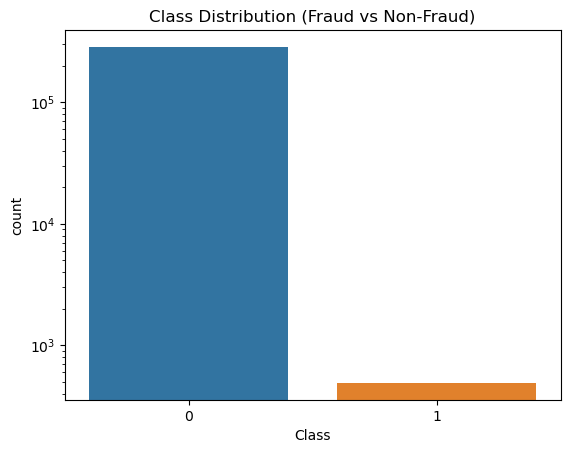

In [4]:
# Check for class imbalance
sns.countplot(x='Class', data=raw_df, log=True)
plt.title('Class Distribution (Fraud vs Non-Fraud)')
plt.show()

**Takeaway:** The dataset is a highly class imbalanced dataset with only ~500 fraud transactions among over 280k total transactions. 

**Implications:** 
* As suggested in the Kaggle data card page, use Area Under the Precision-Recall Curve (AUPRC) as the main metric for model evaluation.
* Might need to use SMOTE to manage class imbalance. 

In [5]:
# Descriptive statistics for the PCA-transformed variables (V1 to V28)
print(raw_df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

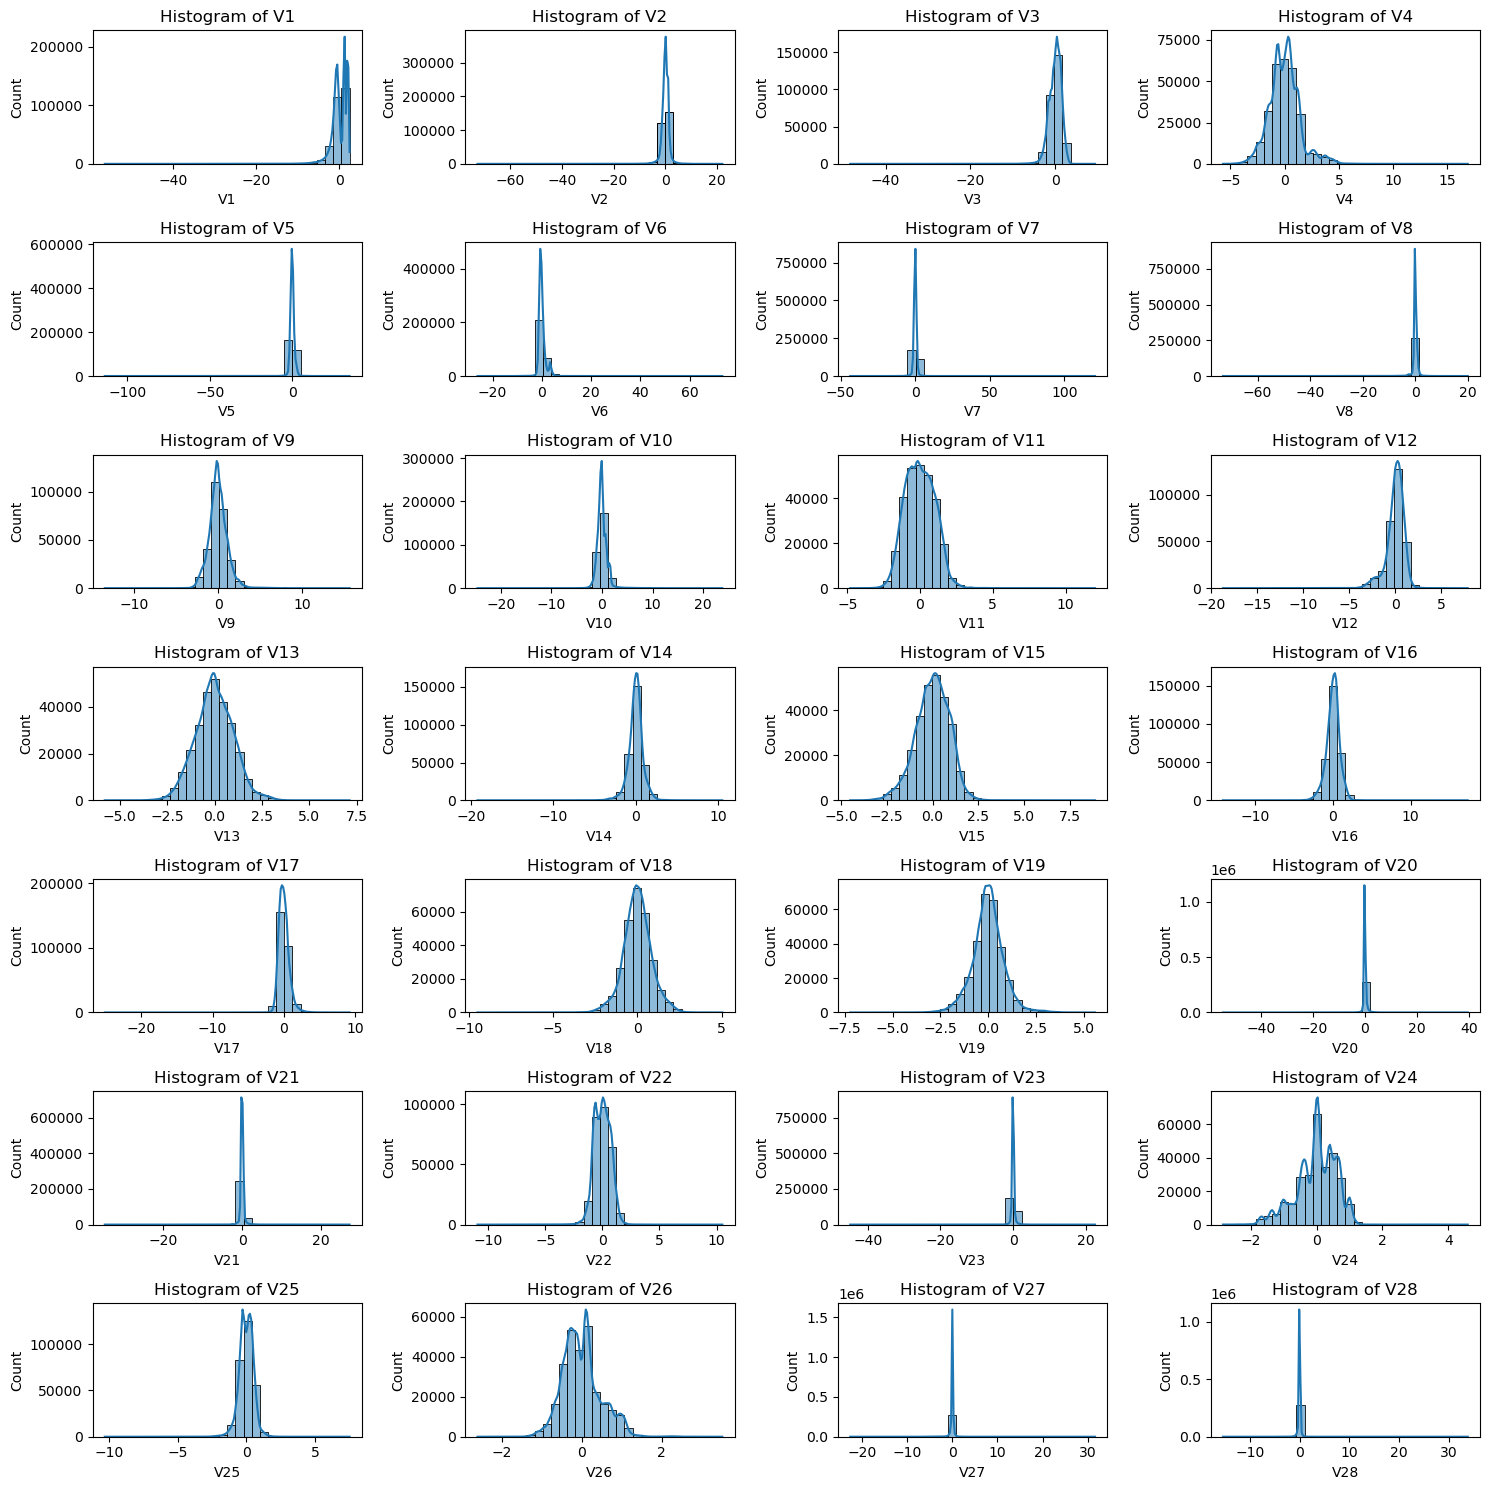

In [6]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Plot histograms of the PCA variables V1 to V28
plt.figure(figsize=(15, 15))
for i in range(1, 29):  # V1 to V28
    plt.subplot(7, 4, i)  # Create a grid of subplots (7 rows, 4 columns)
    sns.histplot(raw_df[f'V{i}'], kde=True, bins=30)
    plt.title(f'Histogram of V{i}')
    plt.tight_layout()  # To avoid overlap
plt.show()

## Data Preparation
Split the dataset into features and dependent. Build train and test set and use SMOTE to handle imbalanced class. 

In [7]:
# Feature columns (V1 to V28, 'Amount', and 'Time')
X = raw_df.drop(['Class'], axis=1)  # Features (all columns except 'Class')
y = raw_df['Class']  # Target (fraud or non-fraud)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Model Development
Train the following classification models popular for use in fraud detection:
* Logistic Regression
* Decision Tree
* Random Forest
* XGBoost

In [8]:
import time

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')  # For XGBoost, we specify eval_metric to avoid warning
}

# Dictionary to store results
results = {}

# Train models and evaluate performance, with time tracking and storing parameters
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Start timing the training process
    start_train_time = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Start timing the inference process
    start_inference_time = time.time()
    y_pred = model.predict(X_test)
    end_inference_time = time.time()
    inference_time = end_inference_time - start_inference_time
    
    # Calculate accuracy and AUPRC
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    auprc = auc(recall, precision)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'AUPRC': auprc,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'train_time': train_time,
        'inference_time': inference_time,
        'parameters': model.get_params()  # Store the model's parameters
    }

    # Print results including parameters
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"Confusion Matrix:\n{results[model_name]['confusion_matrix']}")
    print(f"Classification Report:\n{results[model_name]['classification_report']}")
    print(f"Model Parameters:\n{results[model_name]['parameters']}")
    print("-" * 50)

Training Logistic Regression...
Model: Logistic Regression
Accuracy: 0.9746
AUPRC: 0.7740
Training Time: 1.8352 seconds
Inference Time: 0.0030 seconds
Confusion Matrix:
[[55423  1441]
 [    8    90]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Model Parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
Training Decision Tree...
Model: Decision Tree
Accuracy: 0.9976
AUPRC: 0.5834
Training Time: 40.0312 sec

**Takeaways:** 
* Random Forest and XGBoost algorithms clearly perform significantly better than Logistic Regression and Decision Trees. So, for the GridSearchCV step, the main focus will be on these 2 algorithms (Random Forest and XGBoost) compared to the latter two.
* Random Forest took a long time to run on my computer as compared to XGBoost. Since credit card transaction fraud detection is a near real-time inference problem, we may need to consider runtime in addition to accuracy. 

### Grid Search for hyperparameter tuning 

In [9]:
# Hyperparameter tuning for each model using GridSearchCV
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'max_depth': [5, 10, 15]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2, 0.5],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
    }
}

# Dictionary to store tuned models
tuned_models = {}

# GridSearchCV for each model
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], 
                               cv=3, scoring='average_precision', verbose=1, n_jobs=-1)
    
    # Fit the model on the resampled training data
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Store the best model
    tuned_models[model_name] = best_model
    
    # Evaluate the best model
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    auprc = auc(recall, precision)
    
    print(f"Best Params: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 50)


Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9746
AUPRC: 0.7727
Confusion Matrix:
[[55424  1440]
 [    8    90]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

--------------------------------------------------
Tuning Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.9842
AUPRC: 0.2706
Confusion Matrix:
[[55982   882]
 [   16    82]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1  

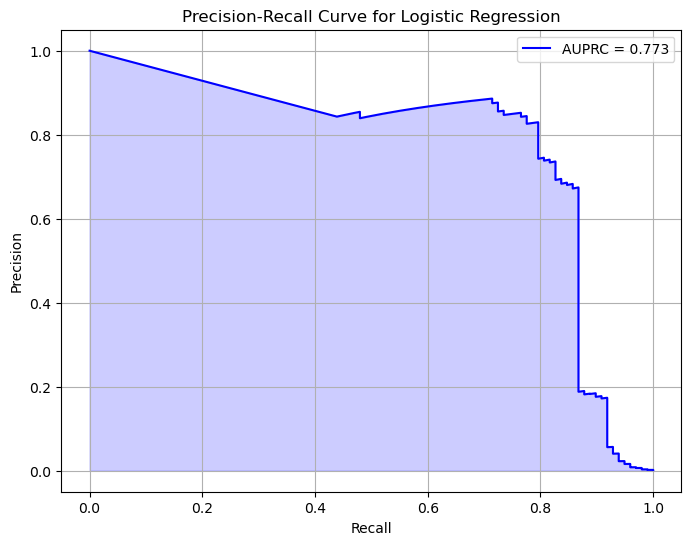

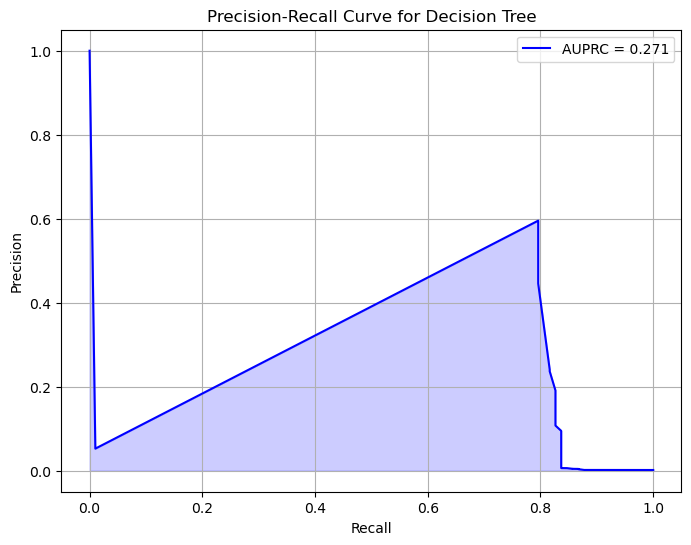

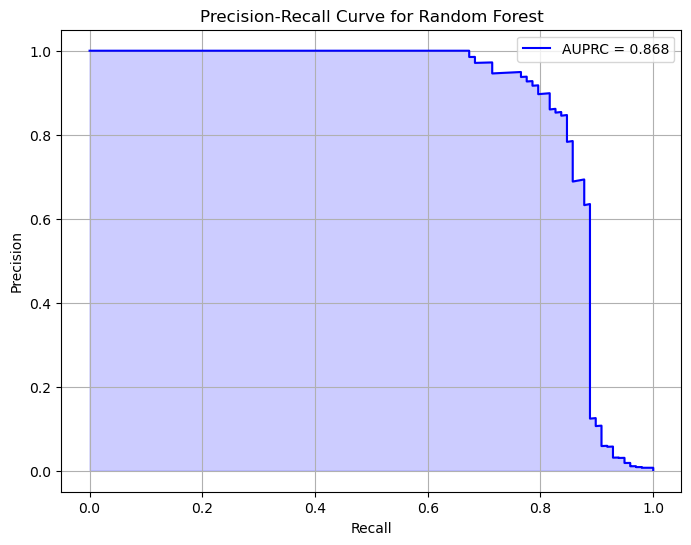

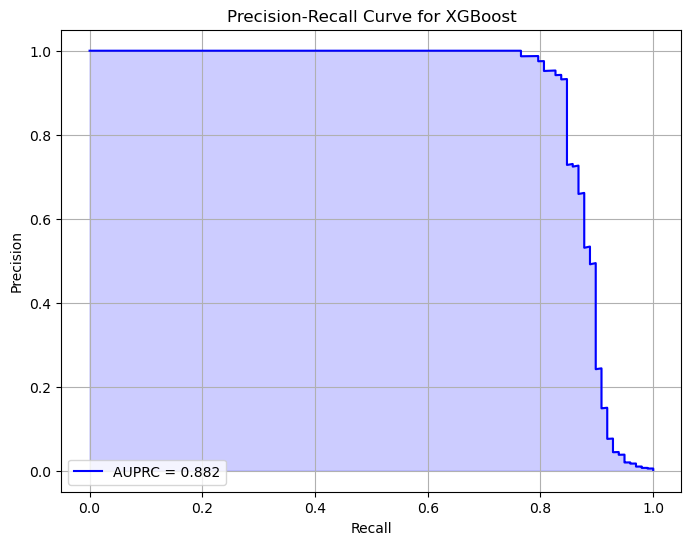

In [56]:
# Function to plot AUPRC for each best-tuned model
def plot_auprc_curve(best_model, X_test, y_test, model_name):
    # Get the predicted probabilities for the positive class
    y_probs = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    
    # Calculate AUPRC (Area Under Precision-Recall Curve)
    pr_auc = auc(recall, precision)
    
    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'AUPRC = {pr_auc:.3f}')
    plt.fill_between(recall, precision, color='blue', alpha=0.2)
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot AUPRC for each of the best models
for model_name in tuned_models:
    best_model = tuned_models[model_name]
    plot_auprc_curve(best_model, X_test, y_test, model_name)
